In [37]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import joblib
import requests_cache
from sklearn.preprocessing import RobustScaler
from metpy.calc import wind_components
from metpy.units import units
from openmeteo_requests import Client
from retry_requests import retry
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")

# API

In [63]:
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
import datetime as dt
import pytz
from retry_requests import retry
from metpy.calc import wind_components
from metpy.units import units

In [69]:
# Function to extract ordered hourly variables 
def get_ordered_hourly_variables(params):
    return params.get("hourly", [])

# Set up API client with caching and retries
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


def get_reading(url, latitude, longtitute, hourly, past_days, future_days):
  params = {
    "latitude": latitude,
    "longitude": longtitute,
    "hourly": hourly,
    "past_days": past_days,
    "forecast_days": future_days
  }

  response = openmeteo.weather_api(url, params=params)[0]
  hourly = response.Hourly()
  hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )
  }
  for i, var_name in enumerate(get_ordered_hourly_variables(params)):
    hourly_data[var_name] = hourly.Variables(i).ValuesAsNumpy()

  #Modify df
  hourly_df = pd.DataFrame(data=hourly_data)
  hourly_df['Date/Time'] = pd.to_datetime(hourly_df['date'], errors='coerce')
  hourly_df.set_index('Date/Time', inplace=True)
  hourly_df.drop(columns=['date'], inplace = True)

  return hourly_df

# Random forest classifier with gradient boosting regression

In [3]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            210384 non-null  object 
 1   Air Dew Point         210384 non-null  float64
 2   Air Temperature (OC)  210384 non-null  float64
 3   Humidity %            210384 non-null  float64
 4   Atmospheric Pressure  210384 non-null  float64
 5   Cloud Cover %         210384 non-null  float64
 6   Wind_U                210384 non-null  float64
 7   Wind_V                210384 non-null  float64
dtypes: float64(7), object(1)
memory usage: 12.8+ MB


In [4]:
df['Cloud Cover %'].unique()

array([  0.  ,  12.5 ,   8.33,  16.67,  25.  ,  45.83,  66.67,  87.5 ,
        62.5 ,  83.33,  37.5 ,  58.33,  29.17,  20.83,  95.83,  75.  ,
        50.  , 100.  ,  91.67,  33.33,  79.17,   4.17,  70.83,  54.17,
        41.67])

In [118]:
df['Cloud Cover %'] = df['Cloud Cover %'].rolling(window=3, center=True).mean()

In [119]:
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df = df[df['time'].dt.year >= 2005].reset_index(drop=True)
# Feature engineering
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month

# Rolling averages (you can tune this)
for col in ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %', 
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']:
    df[f'{col}_roll3'] = df[col].rolling(window=3, min_periods=1).mean()

# Binary target for classification
df['has_cloud'] = (df['Cloud Cover %'] > 0).astype(int)

# Drop unused columns
df = df.drop(columns=['Unnamed: 0', 'time'])

# === 2. Prepare features ===
features = [col for col in df.columns if col not in ['Cloud Cover %', 'has_cloud']]
X = df[features]
y_cls = df['has_cloud']
y_reg = df['Cloud Cover %']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. Split data chronologically (time series split recommended) ===
split_idx = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_cls_train, y_cls_test = y_cls[:split_idx], y_cls[split_idx:]
y_reg_train, y_reg_test = y_reg[:split_idx], y_reg[split_idx:]



In [120]:
# === 4. Step 1: Classification ===
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_cls_train)
cls_preds = clf.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_cls_test, cls_preds))

# === 5. Step 2: Regression only for rows with cloud cover > 0 ===
mask_train = y_cls_train == 1
mask_test = y_cls_test == 1

reg = GradientBoostingRegressor()
reg.fit(X_train[mask_train], y_reg_train[mask_train])
reg_preds = reg.predict(X_test[mask_test])

print("\n--- Regression Metrics ---")
print("MAE:", mean_absolute_error(y_reg_test[mask_test], reg_preds))
print("RMSE:", mean_squared_error(y_reg_test[mask_test], reg_preds))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     17816
           1       0.71      0.69      0.70     15492

    accuracy                           0.73     33308
   macro avg       0.73      0.73      0.73     33308
weighted avg       0.73      0.73      0.73     33308


--- Regression Metrics ---
MAE: 12.7052275545269
RMSE: 240.0125387485204


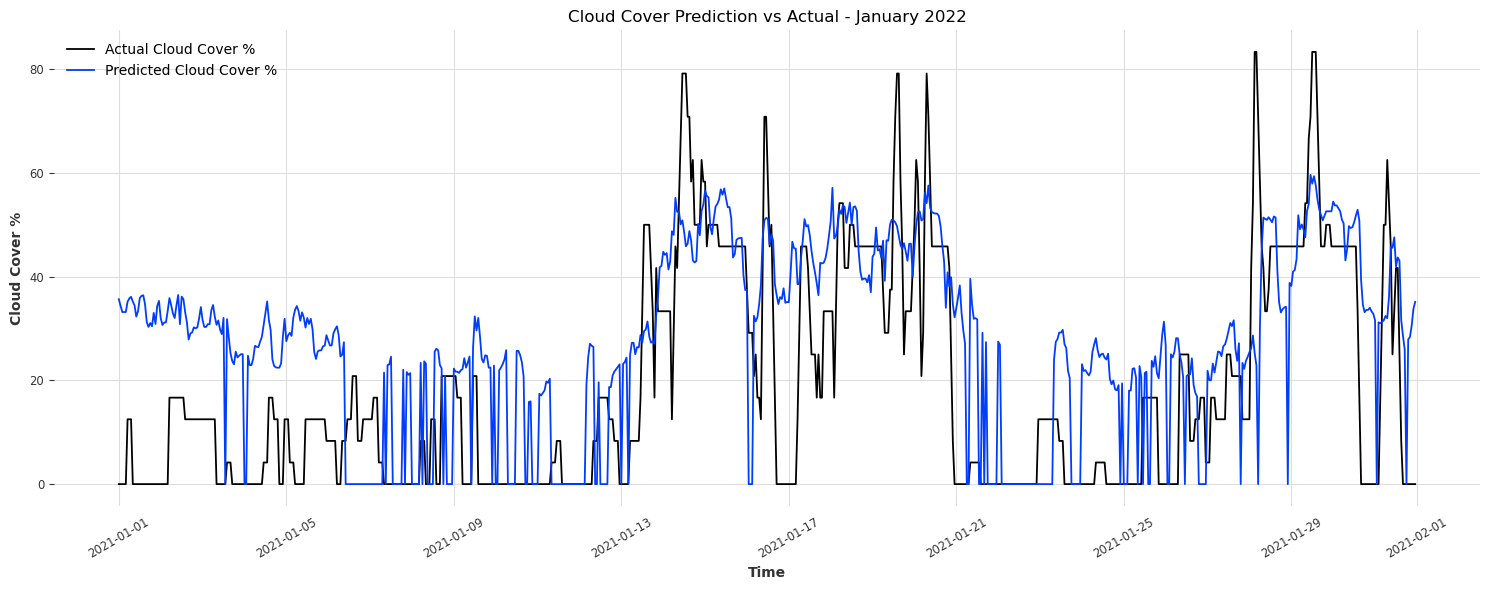


--- January 2022 Metrics ---
MAE: 14.86
RMSE: 351.37


In [123]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year

for col in ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']:
    df[f'{col}_roll3'] = df[col].rolling(window=3, min_periods=1).mean()

df['has_cloud'] = (df['Cloud Cover %'] > 0).astype(int)

# Recompute features
features = [col for col in df.columns if col not in ['Unnamed: 0', 'time', 'Cloud Cover %', 'has_cloud', 'year']]
X_all = df[features]
X_all_scaled = scaler.transform(X_all)

# Create test set (e.g., last 20%)
split_idx = int(len(df) * 0.8)
X_test = X_all_scaled[split_idx:]
y_cls_test = df['has_cloud'].iloc[split_idx:].reset_index(drop=True)
y_reg_test = df['Cloud Cover %'].iloc[split_idx:].reset_index(drop=True)
df_test = df.iloc[split_idx:].reset_index(drop=True)

# --- Prediction ---
cls_preds = clf.predict(X_test)
mask_test = cls_preds == 1
reg_preds = np.zeros_like(y_reg_test)
reg_preds[mask_test] = reg.predict(X_test[mask_test])

df_test['predicted_cloud'] = reg_preds
df_test['actual_cloud'] = y_reg_test
df_test['predicted_has_cloud'] = cls_preds

# --- Filter January 2022 ---
jan2022 = df_test[(df_test['time'].dt.year == 2021) & (df_test['time'].dt.month == 1)]

# --- Plot ---
plt.figure(figsize=(15, 6))
sns.lineplot(data=jan2022, x='time', y='actual_cloud', label='Actual Cloud Cover %')
sns.lineplot(data=jan2022, x='time', y='predicted_cloud', label='Predicted Cloud Cover %')
plt.title("Cloud Cover Prediction vs Actual - January 2022")
plt.ylabel("Cloud Cover %")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Metrics ---
print("\n--- January 2022 Metrics ---")
mae = mean_absolute_error(jan2022['actual_cloud'], jan2022['predicted_cloud'])
rmse = mean_squared_error(jan2022['actual_cloud'], jan2022['predicted_cloud'])
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Model 5

In [77]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            210384 non-null  object 
 1   Air Dew Point         210384 non-null  float64
 2   Air Temperature (OC)  210384 non-null  float64
 3   Humidity %            210384 non-null  float64
 4   Atmospheric Pressure  210384 non-null  float64
 5   Cloud Cover %         210384 non-null  float64
 6   Wind_U                210384 non-null  float64
 7   Wind_V                210384 non-null  float64
dtypes: float64(7), object(1)
memory usage: 12.8+ MB


In [78]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(columns=['Unnamed: 0'], inplace=True)

# Extract datetime features
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month

# Cyclical encoding for time
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


# Final input and output
input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                  'Atmospheric Pressure', 'Wind_U', 'Wind_V']
target_feature = 'Cloud Cover %'

# Train/validation/test split
split_point = int(len(df) * 0.875)
dl_train = df.iloc[:split_point].copy()
dl_val = df.iloc[split_point: split_point + 4320].copy()
dl_test = df.iloc[split_point + 4320:].copy()

In [79]:
# Scale input features
input_scaler = RobustScaler()
input_scaler.fit(dl_train[input_features])
dl_train[input_features] = input_scaler.transform(dl_train[input_features])
dl_val[input_features] = input_scaler.transform(dl_val[input_features])
dl_test[input_features] = input_scaler.transform(dl_test[input_features])

# Scale target separately if needed for loss optimization
target_scaler = RobustScaler()
target_scaler.fit(dl_train[[target_feature]])
dl_train[target_feature] = target_scaler.transform(dl_train[[target_feature]])
dl_val[target_feature] = target_scaler.transform(dl_val[[target_feature]])
dl_test[target_feature] = target_scaler.transform(dl_test[[target_feature]])

# Save scalers
joblib.dump(input_scaler, 'scaler_inputs.save')
joblib.dump(target_scaler, 'scaler_target.save')

['scaler_target.save']

In [80]:
def df_to_X_y(df_X, df_y, window_size=14):
    X, y = [], []
    for i in range(len(df_X) - window_size):
        X.append(df_X.iloc[i:i+window_size].values)
        y.append(df_y.iloc[i + window_size].values)
    return np.array(X), np.array(y)

X_train, y_train = df_to_X_y(dl_train[input_features], dl_train[[target_feature]])
X_val, y_val = df_to_X_y(dl_val[input_features], dl_val[[target_feature]])
X_test, y_test = df_to_X_y(dl_test[input_features], dl_test[[target_feature]])

In [82]:
model = Sequential([
    InputLayer(input_shape=(14, 6)),
    LSTM(64, return_sequences=True),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(0.0001), loss=MeanSquaredError(), metrics=['mse'])

cp = ModelCheckpoint('cloud_model.keras', save_best_only=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])


C:\Users\abood\miniconda3\envs\ml-env\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 170s 29ms/step - loss: 0.4703 - mse: 0.4703 - val_loss: 0.3438 - val_mse: 0.3438
Epoch 2/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 162s 28ms/step - loss: 0.4243 - mse: 0.4243 - val_loss: 0.3347 - val_mse: 0.3347
Epoch 3/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 227s 32ms/step - loss: 0.4109 - mse: 0.4109 - val_loss: 0.3354 - val_mse: 0.3354
Epoch 4/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 195s 31ms/step - loss: 0.4020 - mse: 0.4020 - val_loss: 0.3398 - val_mse: 0.3398
Epoch 5/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 211s 33ms/step - loss: 0.3951 - mse: 0.3951 - val_loss: 0.3458 - val_mse: 0.3458
Epoch 6/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 203s 33ms/step - loss: 0.3894 - mse: 0.3894 - val_loss: 0.3265 - val_mse: 0.3265
Epoch 7/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 200s 33ms/step - loss: 0.3816 - mse: 0.3816 - val_loss: 0.3376 - val_mse: 0.3376
Epoch 8/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 205s 33ms/step - loss: 0.3776 - mse: 0.3776 - val_loss: 0.3617 - val_mse: 0.3617
Epoch 9/10
5753/

687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step


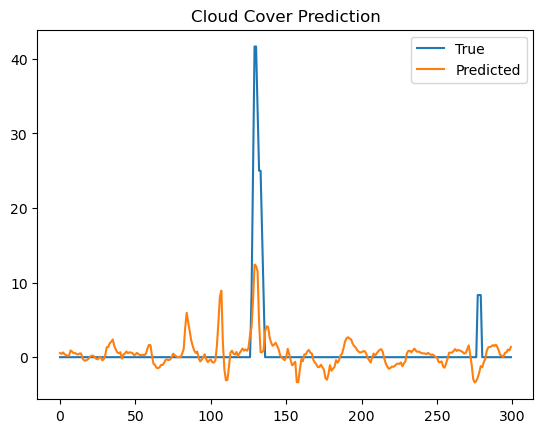

MAE: 9.07875040033918
RMSE: 13.144718808676187
R²: 0.4826554113667637


In [83]:
y_test_pred = model.predict(X_test)
y_test_true = target_scaler.inverse_transform(y_test)
y_test_pred = target_scaler.inverse_transform(y_test_pred)

# Plot
plt.plot(y_test_true[:300], label='True')
plt.plot(y_test_pred[:300], label='Predicted')
plt.title("Cloud Cover Prediction")
plt.legend()
plt.show()

# Metrics
print(f"MAE: {mean_absolute_error(y_test_true, y_test_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_true, y_test_pred))}")
print(f"R²: {r2_score(y_test_true, y_test_pred)}")

In [84]:
def get_forecast_data():
    url = "https://api.open-meteo.com/v1/forecast"
    hourly_vars = [
        "temperature_2m", "wind_speed_10m", "wind_direction_10m",
        "relative_humidity_2m", "dew_point_2m", "pressure_msl"
    ]

    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    client = Client(session=retry_session)

    params = {
        "latitude": 31.95,
        "longitude": 35.91,
        "hourly": hourly_vars,
        "forecast_days": 2
    }

    response = client.weather_api(url, params=params)[0]
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    for i, var in enumerate(hourly_vars):
        hourly_data[var] = hourly.Variables(i).ValuesAsNumpy()

    df = pd.DataFrame(hourly_data)
    df['Date/Time'] = pd.to_datetime(df['date']).dt.tz_convert('Asia/Amman')
    df.set_index('Date/Time', inplace=True)
    df.drop(columns=['date'], inplace=True)

    # Wind conversion
    wind_speed_mps = df['wind_speed_10m'] / 3.6
    u, v = wind_components(
        wind_speed_mps.values * units('m/s'),
        df['wind_direction_10m'].values * units.degree
    )

    df['Wind_U'] = u.magnitude
    df['Wind_V'] = v.magnitude

    # Rename for input
    df = df.rename(columns={
        'dew_point_2m': 'Air Dew Point',
        'temperature_2m': 'Air Temperature (OC)',
        'relative_humidity_2m': 'Humidity %',
        'pressure_msl': 'Atmospheric Pressure'
    })

    return df[[col for col in input_features]].dropna()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step


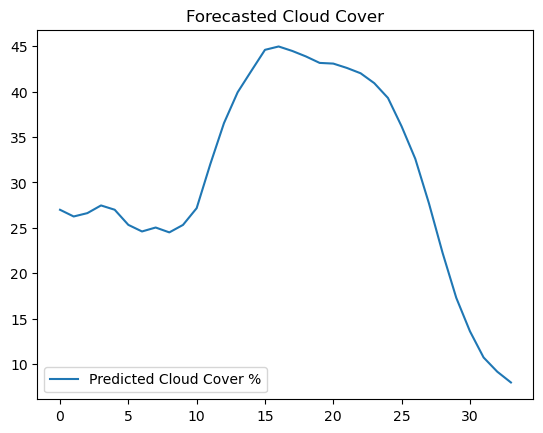

In [85]:
model = tf.keras.models.load_model('cloud_model.keras')
input_scaler = joblib.load('scaler_inputs.save')
target_scaler = joblib.load('scaler_target.save')

# Get and prepare forecast
forecast_df = get_forecast_data()
forecast_df[input_features] = input_scaler.transform(forecast_df[input_features])

# Create sequences for prediction
def create_forecast_sequences(df, window_size=14):
    sequences = []
    for i in range(len(df) - window_size):
        sequences.append(df.iloc[i:i+window_size].values)
    return np.array(sequences)

X_forecast = create_forecast_sequences(forecast_df)

# Predict
forecast_preds_scaled = model.predict(X_forecast)
forecast_preds = target_scaler.inverse_transform(forecast_preds_scaled)

# Plot
plt.plot(forecast_preds, label='Predicted Cloud Cover %')
plt.title("Forecasted Cloud Cover")
plt.legend()
plt.show()

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


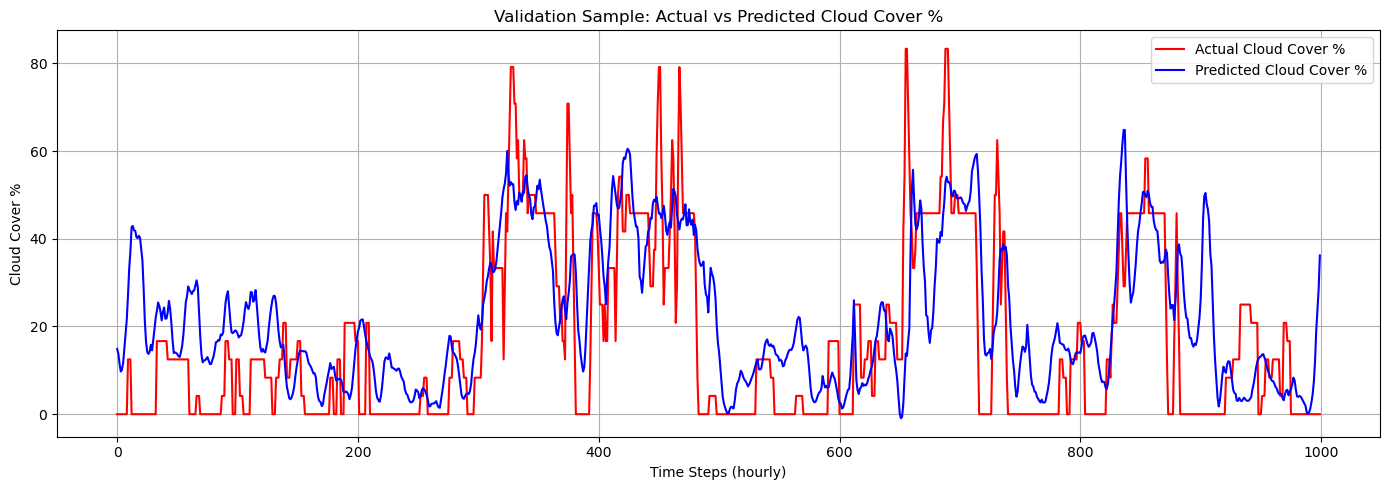

In [90]:
val_preds_scaled = lstm_model2.predict(X_val)

# --- Inverse transform (convert back to original cloud cover scale) ---
val_preds = scaler.inverse_transform(np.concatenate([val_preds_scaled], axis=1))
val_actual = scaler.inverse_transform(np.concatenate([y_val], axis=1))

# --- Plot: Actual vs Predicted on Validation Sample ---
sample_size = 1000  # change to 1000, etc., for longer comparison

plt.figure(figsize=(14, 5))
plt.plot(val_actual[:sample_size], label='Actual Cloud Cover %', color='red')
plt.plot(val_preds[:sample_size], label='Predicted Cloud Cover %', color='blue')
plt.title("Validation Sample: Actual vs Predicted Cloud Cover %")
plt.xlabel("Time Steps (hourly)")
plt.ylabel("Cloud Cover %")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
forecast_df.head()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Wind_U,Wind_V
Date/Time,,,,,,
2025-05-04 03:00:00+03:00,-0.138170,-0.238571,0.071751,-0.114941,-0.071782,-5.038682e-09
2025-05-04 04:00:00+03:00,-0.122087,-0.285000,0.145976,-0.137931,-0.071782,3.521123e-01
2025-05-04 05:00:00+03:00,-0.070613,-0.324286,0.244943,-0.149422,0.076733,2.112682e-01
2025-05-04 06:00:00+03:00,-0.113859,-0.367143,0.269685,-0.114941,0.002475,4.225356e-01
2025-05-04 07:00:00+03:00,-0.069456,-0.306429,0.220202,-0.045978,0.027228,3.521118e-01


# Precipitation Model

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [15]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(columns=['Unnamed: 0'], inplace=True)


In [17]:



# Add cyclical time features
df['hour'] = df['time'].dt.hour
df['dayofyear'] = df['time'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)


# Scale features
features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Create target: rain on *next day*
df['date'] = df['time'].dt.date
rain_per_day = df.groupby('date')['Liquid Precipitation'].sum()
rain_tomorrow = (rain_per_day.shift(-1) > 0).astype(int)
df['RainTomorrow'] = df['date'].map(rain_tomorrow)

# Drop incomplete target rows
df = df.dropna(subset=['RainTomorrow'])


In [34]:
class RainPredictionDataset(Dataset, df, features):
    def __init__(self, df, seq_len=48, forecast_horizon=24):
        self.seq_len = seq_len
        self.forecast_horizon = forecast_horizon
        self.features = df[features].values.astype(np.float32)
        self.timestamps = df['time'].reset_index(drop=True)
        self.precip = df['Liquid Precipitation'].reset_index(drop=True).values
        self.X, self.y = [], []

        # Slide across the time series
        total_len = len(df)
        for i in range(total_len - seq_len - forecast_horizon):
            x_window = self.features[i:i+seq_len]
            y_future = self.precip[i+seq_len:i+seq_len+forecast_horizon]

            # Check if timestamps are contiguous hourly
            start_time = self.timestamps[i]
            end_time = self.timestamps[i + seq_len + forecast_horizon - 1]
            expected_hours = seq_len + forecast_horizon - 1
            if (end_time - start_time).total_seconds() / 3600 != expected_hours:
                continue  # skip if gap in timestamps

            y = float(np.sum(y_future) > 0)  # 1 if any rain in next day
            self.X.append(x_window)
            self.y.append(y)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [19]:


class RainLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(RainLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # output = probability
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # hn: (num_layers, batch, hidden)
        return self.fc(hn[-1])     # Use last layer hidden state


In [35]:
full_dataset = RainPredictionDataset(df)


In [36]:
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Prepare datasets


# Time-based split (e.g., 80% train, 20% val)
train_cutoff = int(len(full_dataset) * 0.8)
train_ds = torch.utils.data.Subset(full_dataset, range(train_cutoff))
val_ds = torch.utils.data.Subset(full_dataset, range(train_cutoff, len(full_dataset)))



In [37]:
# Train
model = RainLSTM(input_size=len(features)).to(device)

# DataLoaders with larger batch size
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=256, pin_memory=True)

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Training Loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True).unsqueeze(1)
        
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1 - Loss: 0.1904
Epoch 2 - Loss: 0.1511
Epoch 3 - Loss: 0.1354
Epoch 4 - Loss: 0.1188
Epoch 5 - Loss: 0.1008
Epoch 6 - Loss: 0.0816
Epoch 7 - Loss: 0.0650
Epoch 8 - Loss: 0.0524
Epoch 9 - Loss: 0.0426
Epoch 10 - Loss: 0.0377


In [29]:
print("Total samples in dataset:", len(full_dataset))

Total samples in dataset: 210312


In [38]:
model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        prob = model(X_batch)  # Output: probability of rain
        print(prob[:5])        # Example predictions
        break

tensor([[0.9970],
        [0.9989],
        [0.9999],
        [1.0000],
        [1.0000]], device='cuda:0')


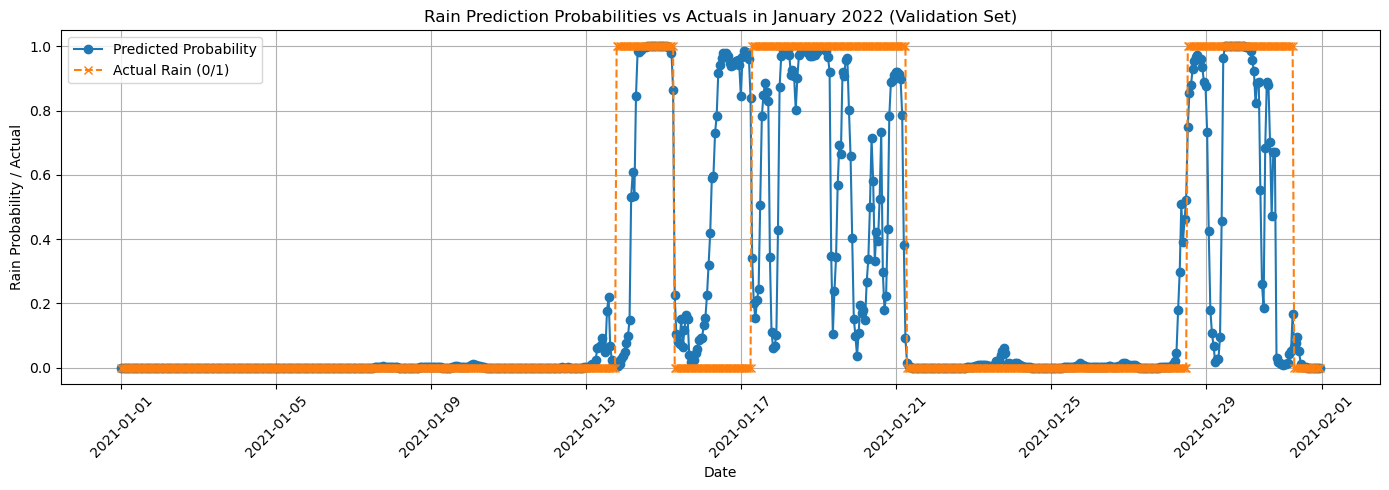

In [43]:
jan_preds = []
jan_actuals = []
jan_timestamps = []

with torch.no_grad():
    for subset_idx in val_ds.indices:
        x, y = full_dataset[subset_idx]
        timestamp_idx = subset_idx + full_dataset.seq_len
        if timestamp_idx >= len(full_dataset.timestamps):
            continue

        timestamp = full_dataset.timestamps[timestamp_idx]

        # Filter for January 2022 only
        if timestamp.month == 1 and timestamp.year == 2021:
            x_tensor = x.unsqueeze(0).to(device)
            pred = model(x_tensor).cpu().item()
            jan_preds.append(pred)
            jan_actuals.append(float(y))
            jan_timestamps.append(timestamp)

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Timestamp': jan_timestamps,
    'Predicted Probability': jan_preds,
    'Actual': jan_actuals
}).sort_values('Timestamp')

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df_plot['Timestamp'], df_plot['Predicted Probability'], label='Predicted Probability', marker='o')
plt.plot(df_plot['Timestamp'], df_plot['Actual'], label='Actual Rain (0/1)', linestyle='--', marker='x')
plt.title('Rain Prediction Probabilities vs Actuals in January 2022 (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Rain Probability / Actual')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
torch.save(model.state_dict(), "Precipitation_test_1.pth")

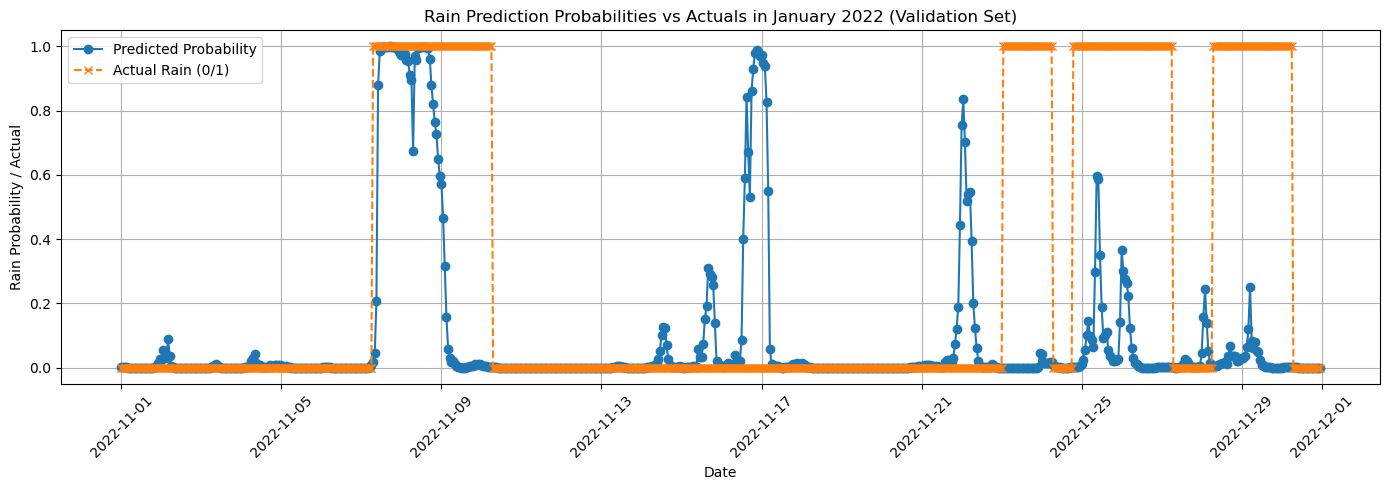

In [51]:
jan_preds = []
jan_actuals = []
jan_timestamps = []

with torch.no_grad():
    for subset_idx in val_ds.indices:
        x, y = full_dataset[subset_idx]
        timestamp_idx = subset_idx + full_dataset.seq_len
        if timestamp_idx >= len(full_dataset.timestamps):
            continue

        timestamp = full_dataset.timestamps[timestamp_idx]

        # Filter for January 2022 only
        if timestamp.month == 11 and timestamp.year == 2022:
            x_tensor = x.unsqueeze(0).to(device)
            pred = model(x_tensor).cpu().item()
            jan_preds.append(pred)
            jan_actuals.append(float(y))
            jan_timestamps.append(timestamp)

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Timestamp': jan_timestamps,
    'Predicted Probability': jan_preds,
    'Actual': jan_actuals
}).sort_values('Timestamp')

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df_plot['Timestamp'], df_plot['Predicted Probability'], label='Predicted Probability', marker='o')
plt.plot(df_plot['Timestamp'], df_plot['Actual'], label='Actual Rain (0/1)', linestyle='--', marker='x')
plt.title('Rain Prediction Probabilities vs Actuals in January 2022 (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Rain Probability / Actual')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cloud model

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(columns=['Unnamed: 0'], inplace=True)

In [65]:
features = [
    "Air Dew Point",
    "Air Temperature (OC)",
    "Humidity %",
    "Atmospheric Pressure",
    "Wind_U",
    "Wind_V"
]

In [66]:
df['hour'] = df['time'].dt.hour
df['dayofyear'] = df['time'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)


# Scale features
features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [67]:
class CloudCoverPredictionDataset(Dataset):
    def __init__(self, df, seq_len=48, forecast_horizon=24):
        self.seq_len = seq_len
        self.forecast_horizon = forecast_horizon
        self.features = df[features].values.astype(np.float32)
        self.timestamps = df['time'].reset_index(drop=True)
        self.cloud_cover = df['Cloud Cover %'].reset_index(drop=True).values.astype(np.float32)
        self.X, self.y = [], []

        total_len = len(df)
        for i in range(total_len - seq_len - forecast_horizon):
            x_window = self.features[i:i+seq_len]
            y_future = self.cloud_cover[i+seq_len:i+seq_len+forecast_horizon]

            # Ensure timestamps are continuous hourly
            start_time = self.timestamps[i]
            end_time = self.timestamps[i + seq_len + forecast_horizon - 1]
            expected_hours = seq_len + forecast_horizon - 1
            if (end_time - start_time).total_seconds() / 3600 != expected_hours:
                continue

            y = float(np.mean(y_future))
            self.X.append(x_window)
            self.y.append(y)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [68]:
class CloudCoverLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(CloudCoverLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [69]:
split_date = pd.to_datetime("2022-12-31")
train_df = df[df["time"] < split_date].copy()
val_df = df[df["time"] >= split_date].copy()

train_ds = CloudCoverPredictionDataset(train_df)
val_ds = CloudCoverPredictionDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=256, pin_memory=True)

In [70]:
model = CloudCoverLSTM(input_size=len(features)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 23
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(X_batch)

    avg_loss = epoch_loss / len(train_ds)
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f}")

Epoch 1/23 - Train Loss: 212.5466
Epoch 2/23 - Train Loss: 132.4765
Epoch 3/23 - Train Loss: 119.6675
Epoch 4/23 - Train Loss: 110.0474
Epoch 5/23 - Train Loss: 99.6682
Epoch 6/23 - Train Loss: 88.3621
Epoch 7/23 - Train Loss: 79.4254
Epoch 8/23 - Train Loss: 70.2352
Epoch 9/23 - Train Loss: 63.5228
Epoch 10/23 - Train Loss: 54.9156
Epoch 11/23 - Train Loss: 49.5170
Epoch 12/23 - Train Loss: 45.4958
Epoch 13/23 - Train Loss: 39.5761
Epoch 14/23 - Train Loss: 36.6482
Epoch 15/23 - Train Loss: 34.6345
Epoch 16/23 - Train Loss: 32.6647
Epoch 17/23 - Train Loss: 29.1664
Epoch 18/23 - Train Loss: 26.3733
Epoch 19/23 - Train Loss: 24.0467
Epoch 20/23 - Train Loss: 22.2673
Epoch 21/23 - Train Loss: 20.2696
Epoch 22/23 - Train Loss: 19.4616
Epoch 23/23 - Train Loss: 18.8449


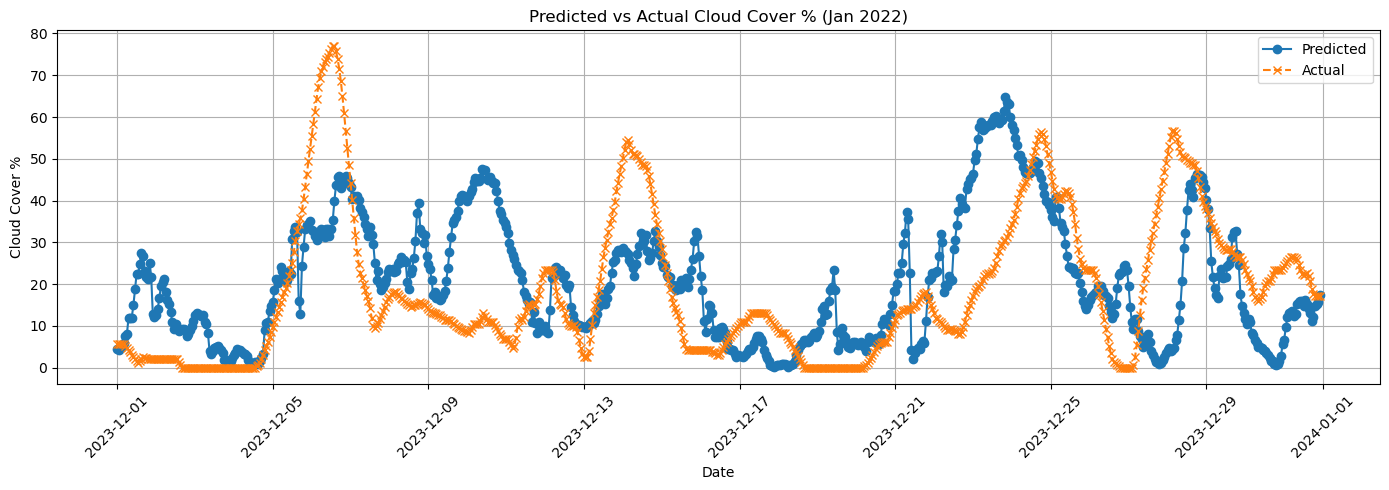

In [71]:
model.eval()
timestamps, preds, actuals = [], [], []

with torch.no_grad():
    for i in range(len(val_ds)):
        x, y = val_ds[i]
        timestamp_idx = i + val_ds.seq_len + val_ds.forecast_horizon - 1
        if timestamp_idx >= len(val_df):
            continue

        timestamp = val_df.iloc[timestamp_idx]["time"]
        if not (timestamp.year == 2023 and timestamp.month == 12):
            continue

        pred = model(x.unsqueeze(0).to(device)).cpu().item()
        preds.append(pred)
        actuals.append(float(y))
        timestamps.append(timestamp)

# Create plot
plot_df = pd.DataFrame({
    "Timestamp": timestamps,
    "Predicted Cloud Cover %": preds,
    "Actual Cloud Cover %": actuals
}).sort_values("Timestamp")

plt.figure(figsize=(14, 5))
plt.plot(plot_df["Timestamp"], plot_df["Predicted Cloud Cover %"], label="Predicted", marker='o')
plt.plot(plot_df["Timestamp"], plot_df["Actual Cloud Cover %"], label="Actual", linestyle="--", marker='x')
plt.title("Predicted vs Actual Cloud Cover % (Jan 2022)")
plt.xlabel("Date")
plt.ylabel("Cloud Cover %")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

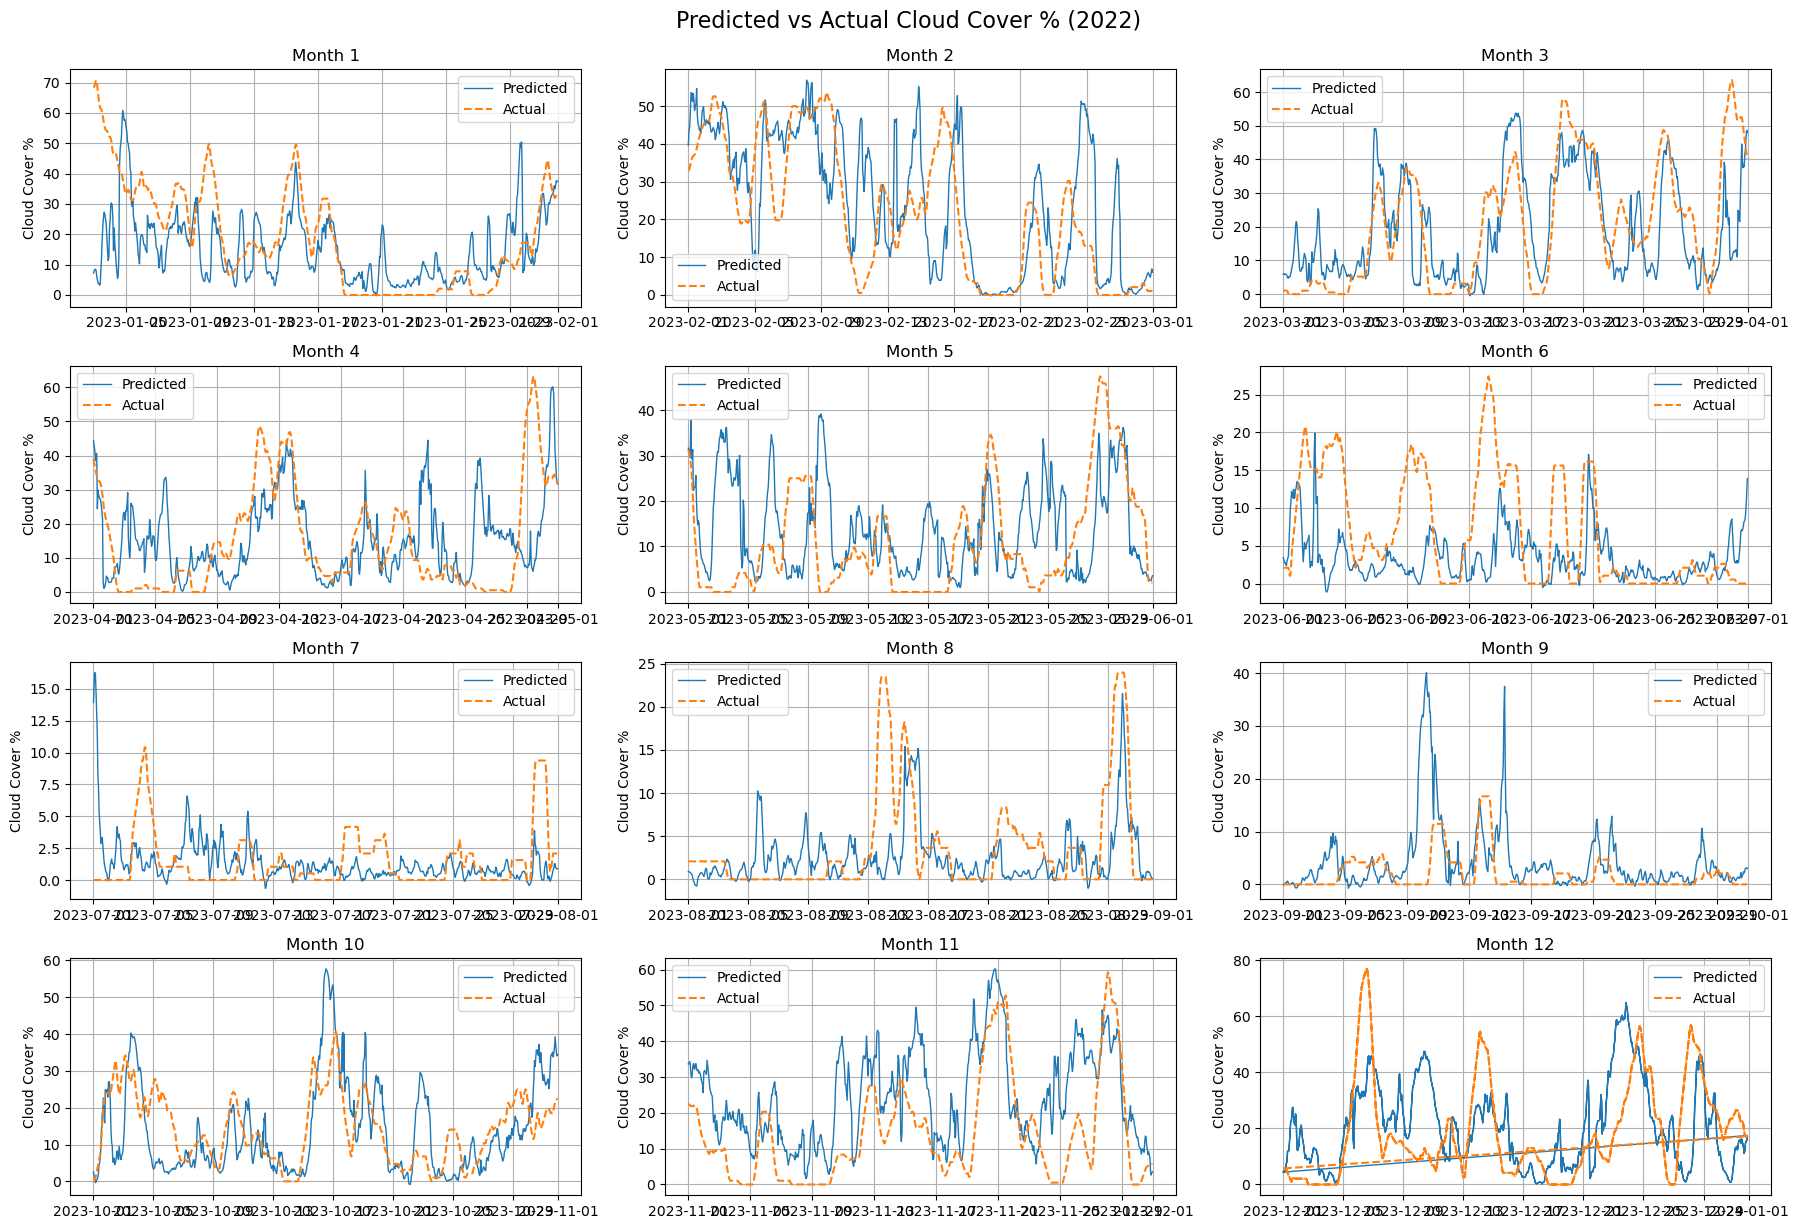

In [72]:
with torch.no_grad():
    for i in range(len(val_ds)):
        x, y = val_ds[i]
        timestamp_idx = i + val_ds.seq_len + val_ds.forecast_horizon - 1
        if timestamp_idx >= len(val_df):
            continue

        timestamp = val_df.iloc[timestamp_idx]["time"]
        if timestamp.year != 2023:
            continue

        pred = model(x.unsqueeze(0).to(device)).cpu().item()
        preds.append(pred)
        actuals.append(float(y))
        timestamps.append(timestamp)

# Create dataframe
plot_df = pd.DataFrame({
    "Timestamp": timestamps,
    "Predicted": preds,
    "Actual": actuals
})
plot_df["Month"] = plot_df["Timestamp"].dt.month

# Plot: one subplot per month
fig, axes = plt.subplots(4, 3, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for month in range(1, 13):
    month_df = plot_df[plot_df["Month"] == month]
    ax = axes[month - 1]
    ax.plot(month_df["Timestamp"], month_df["Predicted"], label="Predicted", linewidth=1)
    ax.plot(month_df["Timestamp"], month_df["Actual"], label="Actual", linestyle="--")
    ax.set_title(f"Month {month}")
    ax.set_ylabel("Cloud Cover %")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle("Predicted vs Actual Cloud Cover % (2022)", fontsize=16, y=1.02)
plt.show()

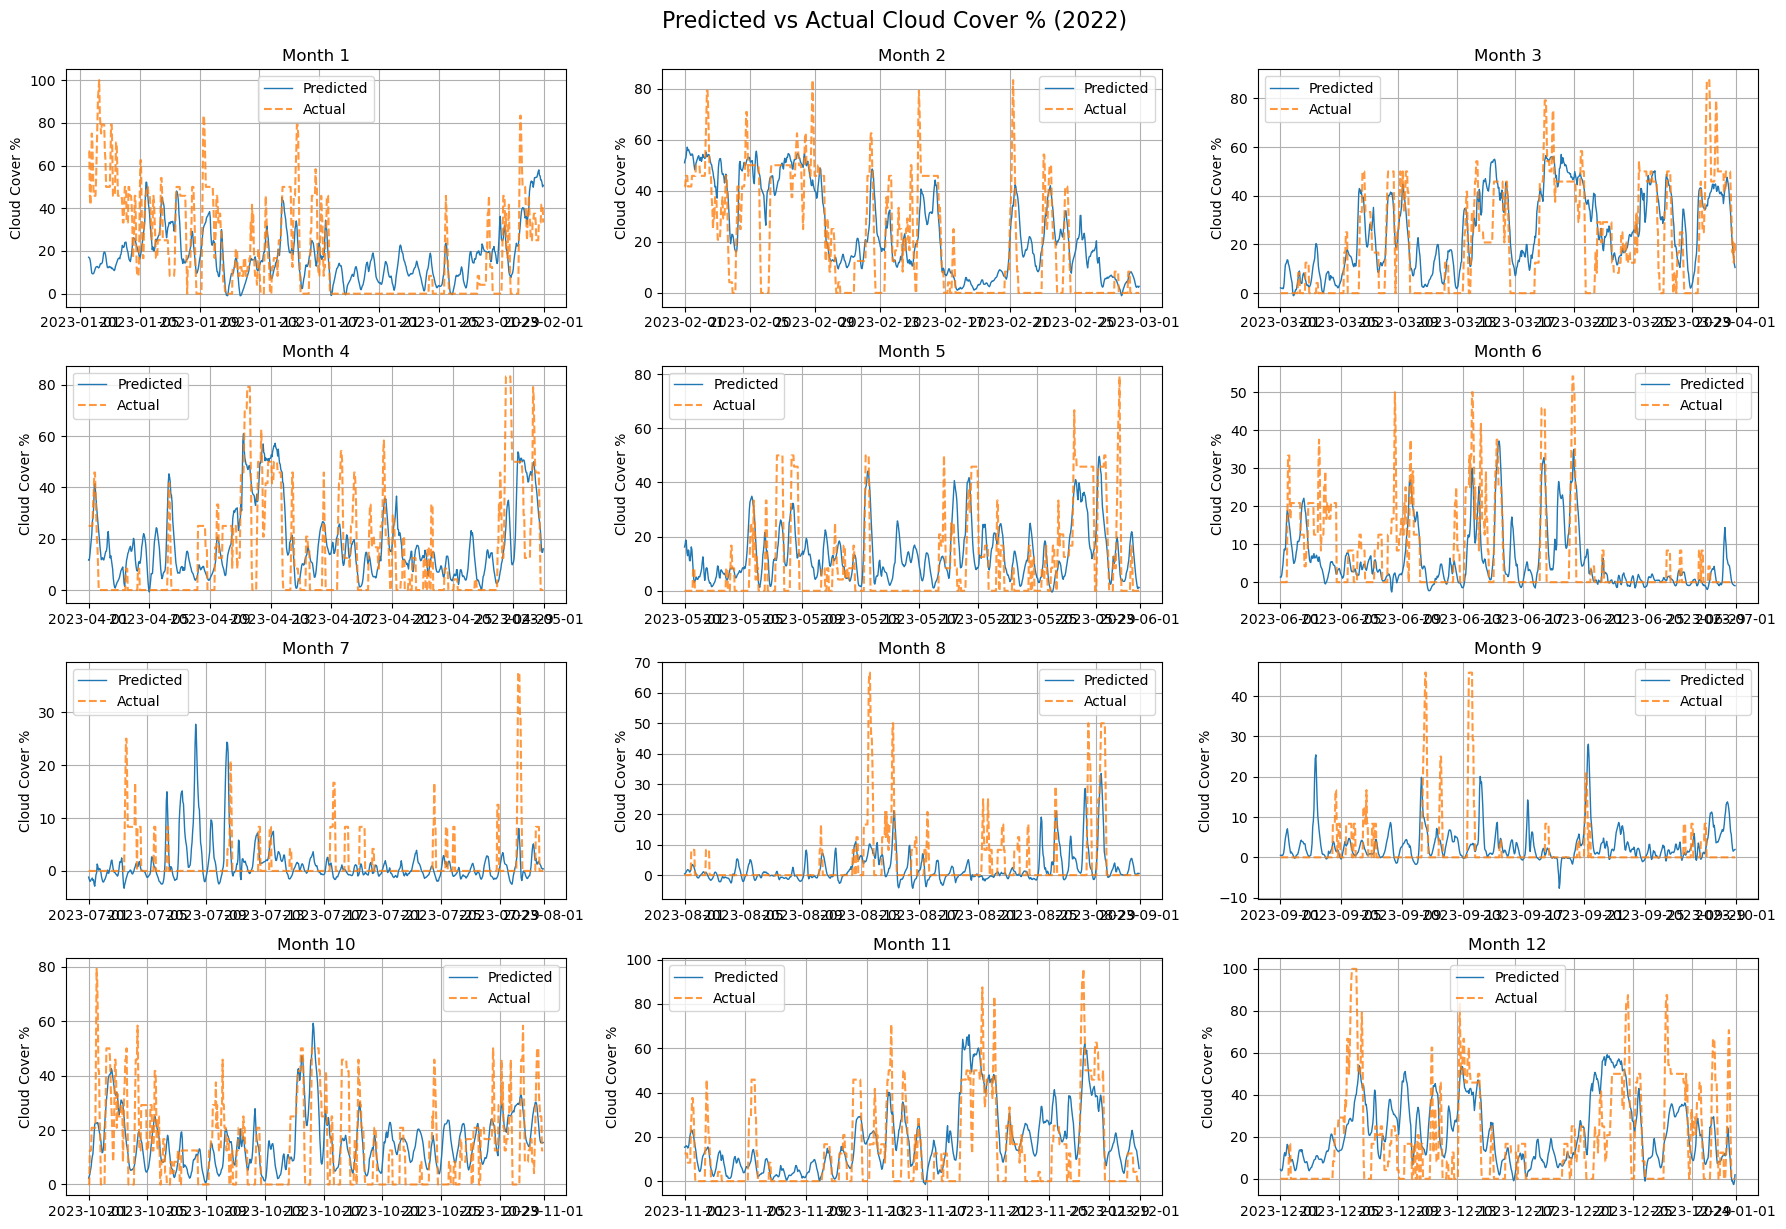

In [74]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(columns=['Unnamed: 0'], inplace=True)

# Extract time features
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Features and target
input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                  'Atmospheric Pressure', 'Wind_U', 'Wind_V']
target_feature = 'Cloud Cover %'

# Load scalers
input_scaler = joblib.load("scaler_inputs.save")
target_scaler = joblib.load("scaler_target.save")

# Scale inputs
df[input_features] = input_scaler.transform(df[input_features])
df[target_feature] = target_scaler.transform(df[[target_feature]])

# Filter 2022 data
df_2022 = df[df['time'].dt.year == 2023].copy()

# Create sequences for 2022
def df_to_X_y(df_X, df_y, window_size=14):
    X, y, times = [], [], []
    for i in range(len(df_X) - window_size):
        X.append(df_X.iloc[i:i+window_size].values)
        y.append(df_y.iloc[i + window_size].values)
        times.append(df_X.index[i + window_size])
    return np.array(X), np.array(y), times

def df_to_X_y_with_timestamps(df_X, df_y, df_time, window_size=14):
    X, y, times = [], [], []
    for i in range(len(df_X) - window_size):
        X.append(df_X.iloc[i:i+window_size].values)
        y.append(df_y.iloc[i + window_size].values)
        times.append(df_time.iloc[i + window_size])
    return np.array(X), np.array(y), np.array(times)

X_2022, y_2022, timestamps = df_to_X_y_with_timestamps(
    df_2022[input_features], 
    df_2022[[target_feature]], 
    df_2022['time'],
    window_size=14
)

# -------------------------------
# Load model and predict
# -------------------------------

model = load_model("cloud_model.keras")
y_pred_scaled = model.predict(X_2022, verbose=0)

# Inverse scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_2022)

# -------------------------------
# Plot predictions by month
# -------------------------------

results_df = pd.DataFrame({
    "time": timestamps,
    "Predicted": y_pred.flatten(),
    "Actual": y_true.flatten()
})
results_df["Month"] = pd.to_datetime(results_df["time"]).dt.month

fig, axes = plt.subplots(4, 3, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for month in range(1, 13):
    month_df = results_df[results_df["Month"] == month]
    ax = axes[month - 1]
    ax.plot(month_df["time"], month_df["Predicted"], label="Predicted", linewidth=1)
    ax.plot(month_df["time"], month_df["Actual"], label="Actual", linestyle="--", alpha=0.8)
    ax.set_title(f"Month {month}")
    ax.set_ylabel("Cloud Cover %")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle("Predicted vs Actual Cloud Cover % (2022)", fontsize=16, y=1.02)
plt.show()

LSTM2 Performance Metrics:
Mean Absolute Error (MAE): 8.954643778079783
Mean Squared Error (MSE): 167.25936639542445
R2 Score: 0.24543962204594127

LSTM1 Performance Metrics:
Mean Absolute Error (MAE): 9.434913124688789
Mean Squared Error (MSE): 185.7332127465373
R2 Score: 0.4647204335063555


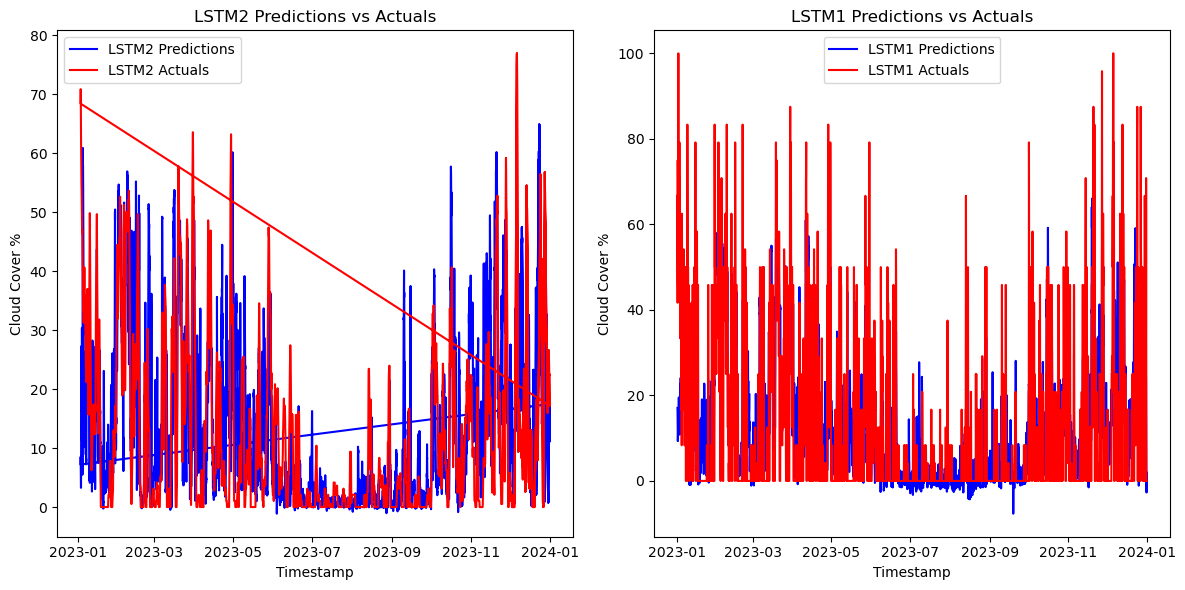

In [76]:


# Ensure the columns match the names of your new dataframes
lstm2_preds = plot_df['Predicted']
lstm2_actuals = plot_df['Actual']

lstm1_preds = results_df['Predicted']
lstm1_actuals = results_df['Actual']

# Performance metrics for LSTM2
lstm2_mae = mean_absolute_error(lstm2_actuals, lstm2_preds)
lstm2_mse = mean_squared_error(lstm2_actuals, lstm2_preds)
lstm2_r2 = r2_score(lstm2_actuals, lstm2_preds)

# Performance metrics for LSTM1
lstm1_mae = mean_absolute_error(lstm1_actuals, lstm1_preds)
lstm1_mse = mean_squared_error(lstm1_actuals, lstm1_preds)
lstm1_r2 = r2_score(lstm1_actuals, lstm1_preds)

# Print out the metrics
print("LSTM2 Performance Metrics:")
print(f"Mean Absolute Error (MAE): {lstm2_mae}")
print(f"Mean Squared Error (MSE): {lstm2_mse}")
print(f"R2 Score: {lstm2_r2}")

print("\nLSTM1 Performance Metrics:")
print(f"Mean Absolute Error (MAE): {lstm1_mae}")
print(f"Mean Squared Error (MSE): {lstm1_mse}")
print(f"R2 Score: {lstm1_r2}")

# Plotting the predictions vs actual values for each model
plt.figure(figsize=(12, 6))

# LSTM2 plot
plt.subplot(1, 2, 1)
plt.plot(plot_df['Timestamp'], lstm2_preds, label='LSTM2 Predictions', color='blue')
plt.plot(plot_df['Timestamp'], lstm2_actuals, label='LSTM2 Actuals', color='red')
plt.title("LSTM2 Predictions vs Actuals")
plt.xlabel("Timestamp")
plt.ylabel("Cloud Cover %")
plt.legend()

# LSTM1 plot
plt.subplot(1, 2, 2)
plt.plot(results_df['time'], lstm1_preds, label='LSTM1 Predictions', color='blue')
plt.plot(results_df['time'], lstm1_actuals, label='LSTM1 Actuals', color='red')
plt.title("LSTM1 Predictions vs Actuals")
plt.xlabel("Timestamp")
plt.ylabel("Cloud Cover %")
plt.legend()

plt.tight_layout()
plt.show()
